# Let's load some libraries

In [1]:
# This are just some graphical parameters to obtain the same figures that are in the paper.
library('ggplot2')
library('latex2exp')
library('gridExtra')
library('cowplot')
library('ggnewscale')

# clusters galaxies
c1 <- rgb(185/255, 18/255, 40/255,1)   #b91228
# backsplash
c2 <- rgb(255/255,133/255,27/255,1)    #ff851b
# infall 
c3 <- rgb(95/255, 75/255, 139/255,1)   #5f4b8b
# recent infallers
c4 <- rgb(61/255, 153/255, 112/255,1)  #3d9970
# interloopers
c5 <- '#808080'


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************




In [2]:
library('ROGER')

Loading required package: randomForest

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:gridExtra’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: caret

Loading required package: lattice

Loading required package: kernlab


Attaching package: ‘kernlab’


The following object is masked from ‘package:ggplot2’:

    alpha




[1] "Welcome to ROGER v1.0"

______________________________________________¶¶¶¶¶¶¶_______
____________________¶¶¶¶¶___________________¶¶¶¶____¶¶______
___________________¶¶¶¶¶¶¶_________________¶¶¶_______¶¶_____
____________________¶¶¶¶¶¶________________¶¶¶________¶¶_____
____________________¶¶¶¶¶_________________¶¶________¶¶______
__________________¶¶¶¶¶¶¶_________________¶¶_______¶¶¶______
_________________¶¶¶¶¶¶¶¶¶¶_______________¶¶_____¶¶¶________
________________¶¶¶¶¶__¶¶¶¶¶¶_____________¶¶__¶¶¶¶¶_________
______________¶¶¶¶¶¶¶___¶¶¶¶¶¶¶__________¶¶¶¶¶¶¶____________
______________¶¶¶¶¶¶¶¶¶___¶¶¶¶¶¶¶¶______¶¶¶¶¶_______________
_____________¶¶¶¶__¶¶¶¶¶¶____¶¶¶¶¶¶¶¶¶¶¶¶¶¶_________________
____________¶¶¶¶¶____¶¶¶¶¶¶¶____¶¶¶¶¶¶¶¶¶¶__________________
____________¶¶¶¶_______¶¶¶¶¶¶¶¶¶_____¶¶¶____________________
____________¶¶¶¶__________¶¶¶¶¶¶¶¶¶¶¶¶¶_____________________
____________¶¶¶¶_______________¶¶¶¶¶¶¶¶_____________________
_____________¶¶¶¶¶______________________________________

# Let's load the trainset

In [3]:
data(trainset)
summary(trainset)

       r               v          real_class
 Min.   :0.000   Min.   :0.0000   CL :3268  
 1st Qu.:0.755   1st Qu.:0.2640   BS :4527  
 Median :1.395   Median :0.5820   IN :7689  
 Mean   :1.478   Mean   :0.8049   RIN:2633  
 3rd Qu.:2.198   3rd Qu.:1.1310   ITL:8253  
 Max.   :3.000   Max.   :3.0000             

In [4]:
# Let's load the ML models
data('knn') 
data('svm')
data('rf')

In [5]:
# Let's load the testing set
data(testCluster)
# Let's see the structure of this data frame
str(testCluster)
# Let's keep only with the 'r' and 'v' columns that will be used to predict, and
# save the real classification for future comparison.

cat        <- testCluster[, c(1, 2)]
real_class <- as.factor(testCluster$real_class)

'data.frame':	1041 obs. of  3 variables:
 $ r         : num  0.968 0.516 1.481 1.969 1.861 ...
 $ v         : num  0.488 2.256 1.383 1.277 0.829 ...
 $ real_class: Factor w/ 5 levels "CL","BS","IN",..: 3 5 5 5 5 3 5 5 5 5 ...


In [6]:
# Let's estimate the probabilities
prob_rf  <- get_class(cat, model = rf, type = 'prob')
prob_knn <- get_class(cat, model = knn, type = 'prob')
prob_svm <- get_class(cat, model = svm, type = 'prob')

In [7]:
# Let's perform a random classification of each galaxy taking into account it's probability
set.seed(28890)

class_rf  <- 1:length(cat$r)
class_knn <- 1:length(cat$r)
class_svm <- 1:length(cat$r)

for(i in 1:length(cat$r)){
  class_rf[i]  <- sample(c('CL','BS','IN','RIN','ITL'), size = 1, prob = prob_rf[i,])
  class_knn[i] <- sample(c('CL','BS','IN','RIN','ITL'), size = 1, prob = prob_knn[i,])
  class_svm[i] <- sample(c('CL','BS','IN','RIN','ITL'), size = 1, prob = prob_svm[i,])
}

ran_test <- data.frame(cat, class_rf, class_knn, class_svm, real_class)

In [8]:
# Let's separate the classes
cl0  <- subset(ran_test, ran_test$real_class == 'CL') # Cluster galaxies
bs0  <- subset(ran_test, ran_test$real_class == 'BS') # Backsplash galaxies
ing0 <- subset(ran_test, ran_test$real_class == 'IN') # Infalling galaxies
rin0 <- subset(ran_test, ran_test$real_class == 'RIN') # Recent infalling galaxies
int0 <- subset(ran_test, ran_test$real_class == 'ITL') # Interlooper galaxies

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]

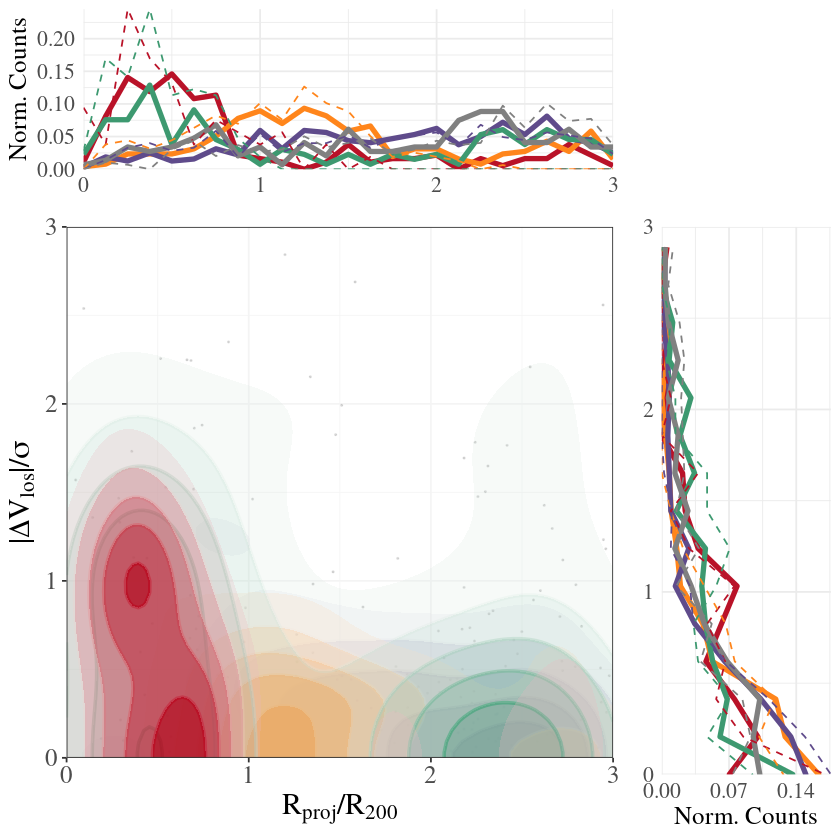

In [9]:
# Let's separete each class taking into account the svm method

cl  <- subset(ran_test, ran_test$class_svm == 'CL') # CLuster galaxies
bs  <- subset(ran_test, ran_test$class_svm == 'BS') # Backsplash galaxies
ing <- subset(ran_test, ran_test$class_svm == 'IN') # Infallin galaxies
rin <- subset(ran_test, ran_test$class_svm == 'RIN') # Recent infalling galaxies
int <- subset(ran_test, ran_test$class_svm == 'ITL') # Interlooper galaxies

plot_ppsd(cl, bs, ing, rin, int,
          cl0 = cl0, bs0 = bs0, ing0 = ing0, rin0 = rin0, int0 = int0, reference = TRUE, hist_bins_y=30)

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]

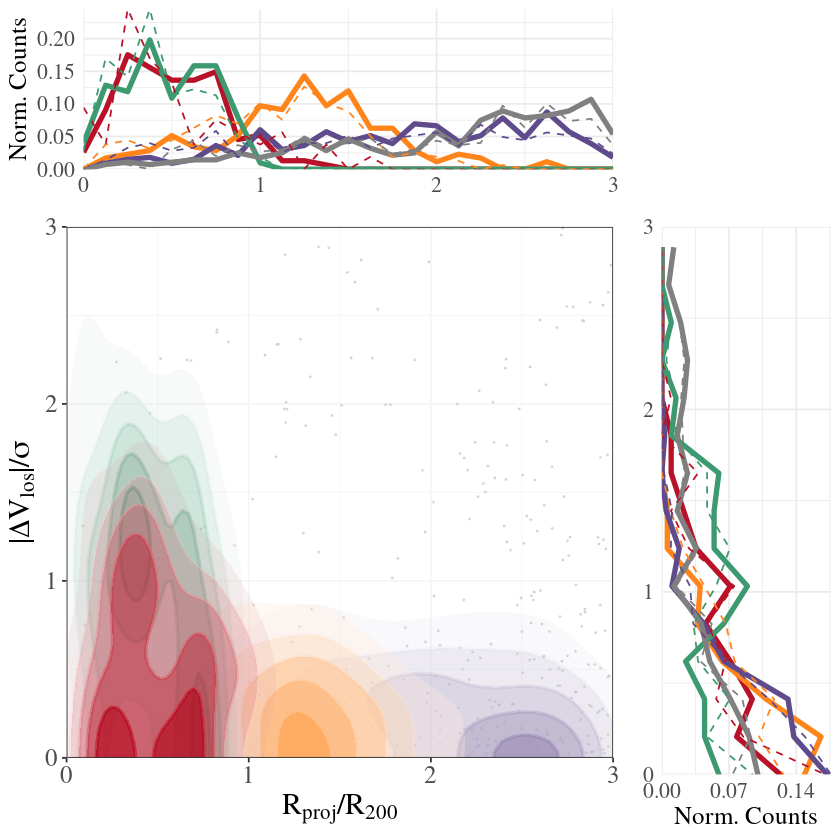

In [10]:
# Let's separete each class taking into account the rf method

cl  <- subset(ran_test, ran_test$class_rf == 'CL') # CLuster galaxies
bs  <- subset(ran_test, ran_test$class_rf == 'BS') # Backsplash galaxies
ing <- subset(ran_test, ran_test$class_rf == 'IN') # Infallin galaxies
rin <- subset(ran_test, ran_test$class_rf == 'RIN') # Recent infalling galaxies
int <- subset(ran_test, ran_test$class_rf == 'ITL') # Interlooper galaxies

plot_ppsd(cl, bs, ing, rin, int,
          cl0 = cl0, bs0 = bs0, ing0 = ing0, rin0 = rin0, int0 = int0, reference = TRUE, hist_bins_y=30)

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]

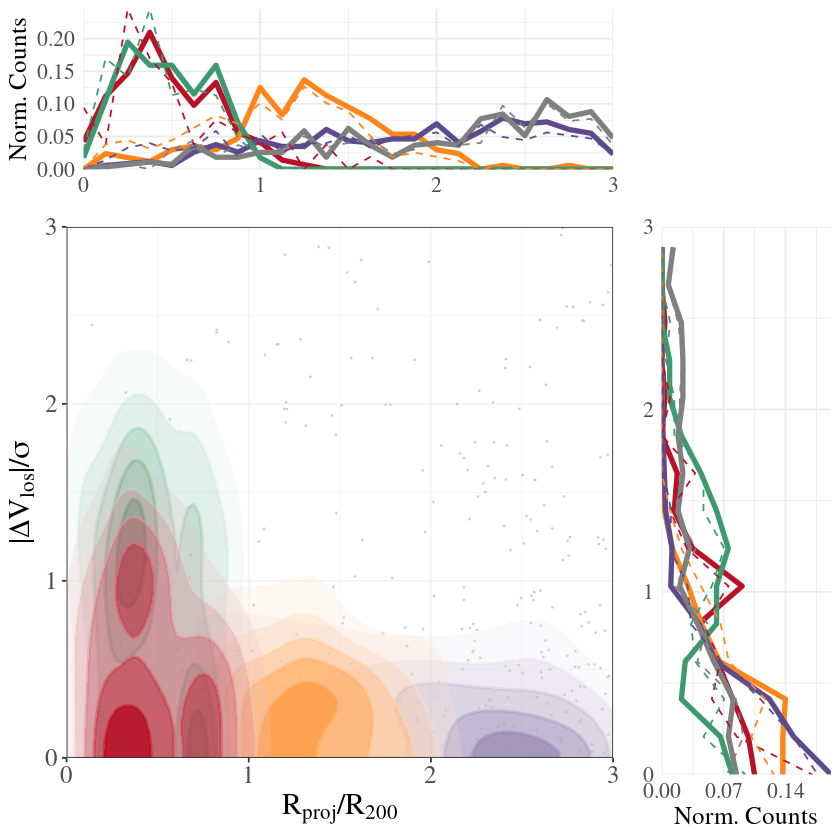

In [11]:
# Let's separete each class taking into account the knn method

cl  <- subset(ran_test, ran_test$class_knn == 'CL') # CLuster galaxies
bs  <- subset(ran_test, ran_test$class_knn == 'BS') # Backsplash galaxies
ing <- subset(ran_test, ran_test$class_knn == 'IN') # Infallin galaxies
rin <- subset(ran_test, ran_test$class_knn == 'RIN') # Recent infalling galaxies
int <- subset(ran_test, ran_test$class_knn == 'ITL') # Interlooper galaxies

plot_ppsd(cl, bs, ing, rin, int,
          cl0 = cl0, bs0 = bs0, ing0 = ing0, rin0 = rin0, int0 = int0, reference = TRUE, hist_bins_y=30)


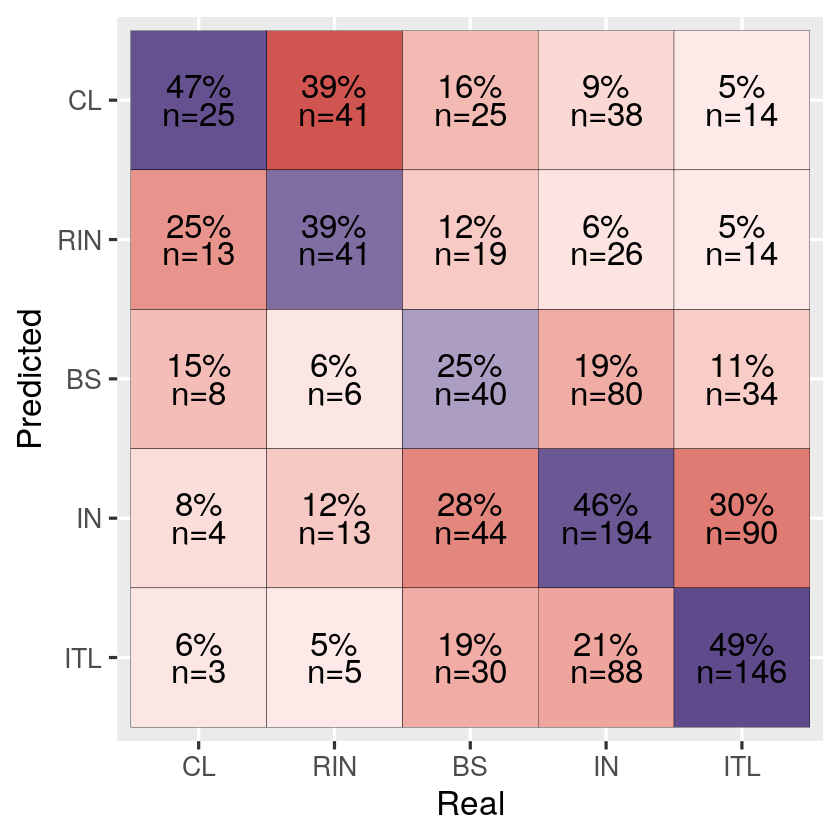

In [12]:
Real            <- real_class
Predict         <- ran_test$class_knn

real_d        <- as.data.frame(table(Real))
names(real_d) <- c("Real", "RealFreq")

# Let's estimate the confusion matrix

cMatrix        <- as.data.frame(table(Real, Predict, useNA = 'ifany'))
names(cMatrix) <- c("Real", "Predicted", "Freq")

cMatrix            <- merge(cMatrix, real_d, by = c('Real', 'Real'))
cMatrix$Percent    <- cMatrix$Freq/cMatrix$RealFreq*100
cMatrix$ColorScale <- cMatrix$Percent*-1
cMatrix[which(cMatrix$Real == cMatrix$Predicted),]$ColorScale <- cMatrix[which(cMatrix$Real == cMatrix$Predicted), ]$ColorScale*-1
cMatrix$Label1 <- paste(round(cMatrix$Percent,0), "%", sep = "")
cMatrix$Label2 <- paste("n=", cMatrix$Freq, sep = "")

ggplot() +
    geom_tile(aes(x = Real, y = Predicted, fill = ColorScale), data = cMatrix, color = "black", size = 0.1) +
    labs(x = "Real", y = "Predicted") +
    theme_grey(base_size = 20) +
    geom_text(aes(x = Real, y = Predicted, label = Label1), data = cMatrix, size = 7, colour = "black", nudge_y = 0.1) +
    geom_text(aes(x = Real, y = Predicted, label = Label2), data = cMatrix, size = 7, colour = "black", nudge_y = -0.1) +
    scale_fill_gradient2(low = c1, high = c3, mid = 'white', midpoint = 0, guide = 'none') +
    xlim('CL', 'RIN', 'BS', 'IN', 'ITL') +
    ylim('ITL', 'IN', 'BS', 'RIN', 'CL')